In [62]:
import pandas as pd
import numpy as np
from tabata.opset import Opset
from dtaidistance import dtw
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [63]:
# Charger les données
input_file = "../Data/normalized/AFL1EB_normalized.h5"
ds = Opset(input_file)

print(f"Nombre total d'enregistrements : {len(ds)}")
ds.plot()

Nombre total d'enregistrements : 47


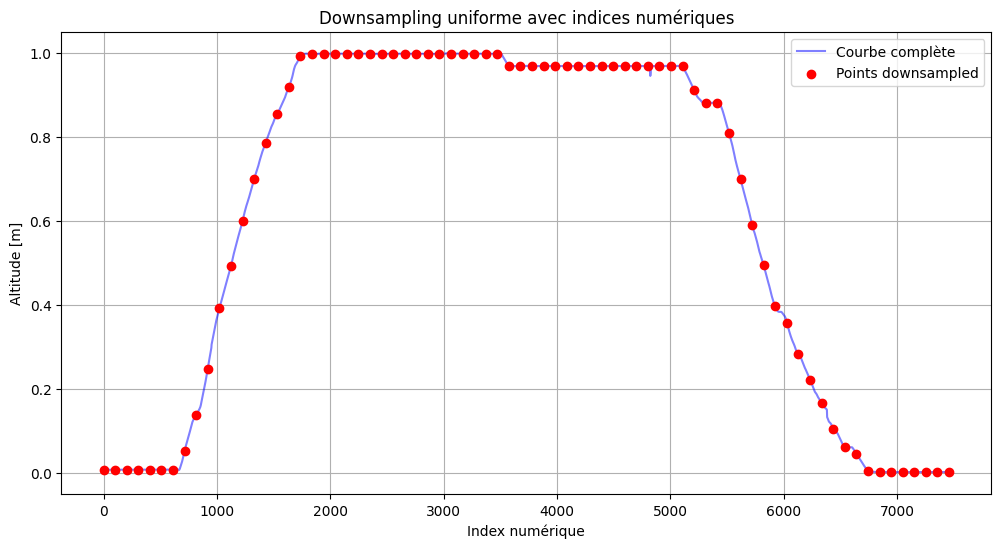

In [79]:
import pandas as pd
import numpy as np
from tabata.opset import Opset
from dtaidistance import dtw
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# Fonction de downsampling uniforme
def downsample_curve_numeric_indices(df, col, ratio):
    """
    Downsample une courbe avec des indices numériques (0 à len(df) - 1).
    """
    total_points = len(df[col])
    num_samples = max(2, int(total_points * ratio))  # Assure au moins 2 points

    # Génération d'indices positionnels uniformes
    sampled_positions = np.round(np.linspace(0, total_points - 1, num_samples)).astype(int)

    # Sélection des lignes correspondant à ces positions
    downsampled_values = df[col].iloc[sampled_positions].values

    # Création d'un DataFrame avec des indices numériques
    downsampled_df = pd.DataFrame(
        {col: downsampled_values},
        index=sampled_positions
    )

    return downsampled_df

# Charger les données
input_file = "../Data/normalized/AFL1EB_normalized.h5"
ds = Opset(input_file)
reference_id = "/record_16"
target_id = "/record_01"

df_reference = ds[ds.records.index(reference_id)]
df_target = ds[ds.records.index(target_id)]

# Downsampling
ratio = 0.01
df_target_downsampled = downsample_curve_numeric_indices(df_target, col="ALT[m]", ratio=ratio)

# Visualisation
plt.figure(figsize=(12, 6))
plt.plot(range(len(df_target["ALT[m]"])), df_target["ALT[m]"].values, label="Courbe complète", color="blue", alpha=0.5)
plt.scatter(df_target_downsampled.index, df_target_downsampled["ALT[m]"], color="red", label="Points downsampled", zorder=3)
plt.xlabel("Index numérique")
plt.ylabel("Altitude [m]")
plt.title("Downsampling uniforme avec indices numériques")
plt.legend()
plt.grid()
plt.show()


Distance DTW : 0.1598114664853114


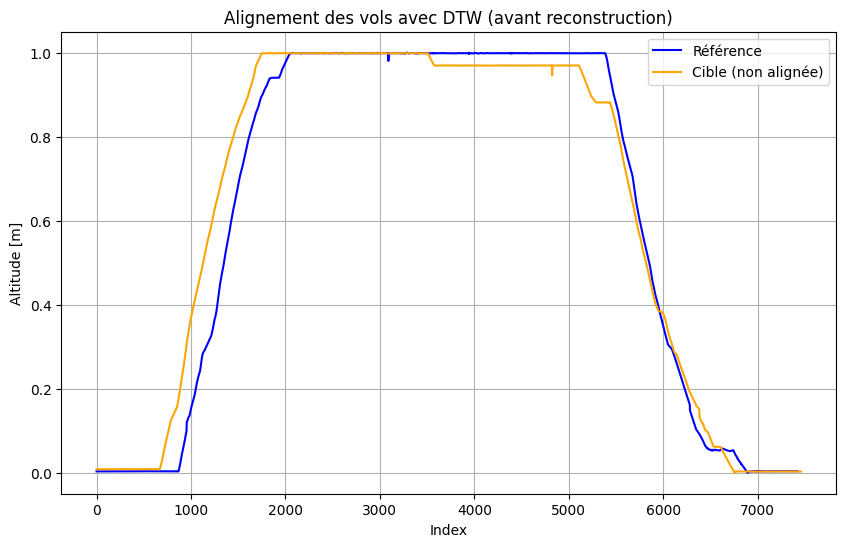

In [80]:
# Alignement avec DTW
def synchronize_with_dtw(reference, target, col="ALT[m]", sakoe_chiba_radius=None):
    ref_sequence = reference[col].values
    target_sequence = target[col].values

    distance, paths = dtw.warping_paths(
        ref_sequence,
        target_sequence,
        window=sakoe_chiba_radius
    )
    print(f"Distance DTW : {distance}")
    
    best_path = dtw.best_path(paths)
    return distance, best_path

# Synchronisation
sakoe_chiba_radius = int(len(df_reference["ALT[m]"]) * 0.01)  # 10 % de la longueur de la séquence
#distance, best_path = synchronize_with_dtw(df_reference, df_target_downsampled, sakoe_chiba_radius=sakoe_chiba_radius)
distance, best_path = synchronize_with_dtw(df_reference, df_target)


# Visualisation de l'alignement
plt.figure(figsize=(10, 6))
plt.plot(df_reference["ALT[m]"].values, label="Référence", color="blue")
plt.plot(df_target["ALT[m]"].values, label="Cible (non alignée)", color="orange")
plt.xlabel("Index")
plt.ylabel("Altitude [m]")
plt.title("Alignement des vols avec DTW (avant reconstruction)")
plt.legend()
plt.grid()
plt.show()


In [74]:
best_path

[(0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 0),
 (6, 0),
 (7, 0),
 (8, 0),
 (9, 0),
 (10, 0),
 (11, 0),
 (12, 0),
 (13, 0),
 (14, 0),
 (15, 0),
 (16, 0),
 (17, 0),
 (18, 0),
 (19, 0),
 (20, 0),
 (21, 0),
 (22, 0),
 (23, 0),
 (24, 0),
 (25, 0),
 (26, 0),
 (27, 0),
 (28, 0),
 (29, 0),
 (30, 0),
 (31, 0),
 (32, 0),
 (33, 0),
 (34, 0),
 (35, 0),
 (36, 0),
 (37, 0),
 (38, 0),
 (39, 0),
 (40, 0),
 (41, 0),
 (42, 0),
 (43, 0),
 (44, 0),
 (45, 0),
 (46, 0),
 (47, 0),
 (48, 0),
 (49, 0),
 (50, 0),
 (51, 0),
 (52, 0),
 (53, 0),
 (54, 0),
 (55, 0),
 (56, 0),
 (57, 0),
 (58, 0),
 (59, 0),
 (60, 0),
 (61, 0),
 (62, 0),
 (63, 0),
 (64, 0),
 (65, 0),
 (66, 0),
 (67, 0),
 (68, 0),
 (69, 0),
 (70, 0),
 (71, 0),
 (72, 0),
 (73, 0),
 (74, 0),
 (75, 0),
 (76, 0),
 (77, 0),
 (78, 0),
 (79, 0),
 (80, 0),
 (81, 0),
 (82, 0),
 (83, 0),
 (84, 0),
 (85, 0),
 (86, 0),
 (87, 0),
 (88, 0),
 (89, 0),
 (90, 0),
 (91, 0),
 (92, 0),
 (93, 0),
 (94, 0),
 (95, 0),
 (96, 0),
 (97, 0),
 (98, 0),
 (99, 0),
 (100, 0),

In [ ]:
def reconstruct_target(target, best_path, col="ALT[m]"):
    target_values = []
    for _, j in best_path:
        target_values.append(target[col].iloc[j])
    
    interp_func = interp1d(range(len(target_values)), target_values, kind='cubic')
    reconstructed_target = interp_func(np.linspace(0, len(target_values) - 1, len(target[col])))
    
    reconstructed_df = pd.DataFrame({
        col: reconstructed_target
    }, index=target.index)
    
    return reconstructed_df